## create dataset 

v3:公開notebookをもとにderivedデータ作成

In [1]:
import pandas as pd
import numpy as np

In [3]:
from pathlib import Path
root_dir = Path('../input/google-smartphone-decimeter-challenge')
# base_train = pd.read_csv(root_dir / 'baseline_locations_train.csv')
# base_test = pd.read_csv(root_dir / 'baseline_locations_test.csv')

# sub = pd.read_csv(root_dir / 'sample_submission.csv')

In [54]:
import glob
import os
from tqdm.notebook import tqdm


def create_train_dataset(collection_path):

    dt_offset = pd.to_datetime('1980-01-06 00:00:00')
    dt_offset_in_ms = int(dt_offset.value / 1e6)

    output_df = pd.DataFrame()
    for phone_path in glob.glob(os.path.join(collection_path, '*')):

        # get derived file (only 1 file)
        for derived_path in glob.glob(os.path.join(phone_path, "*_derived.csv")):
            derived_df = pd.read_csv(derived_path)
        
        # get ground truth file
        target_df = pd.read_csv(phone_path + '/ground_truth.csv')
        target_df['correctedPrM'] = target_df['rawPrM'] + \
                                    target_df['satClkBiasM'] - \
                                    target_df['isrbN'] - \
                                    target_df['ionoDelayM'] - \
                                    target_df['tropoDelayM']
        
        # merge derived and target by 'millisSinceGpsEpoch'
        rows = []
        for epoch, epoch_df in derived_df.groupby('millisSinceGpsEpoch'):

            collectionName = epoch_df.iloc[0, 0]
            phoneName = epoch_df.iloc[0, 1]
            millisSinceGpsEpoch = epoch_df.iloc[0, 2].astype(int)
            idx = (target_df['millisSinceGpsEpoch'] - epoch).abs().argmin()
            epoch_diff = int(epoch) - target_df.loc[idx, 'millisSinceGpsEpoch'].astype(int)
            
            dummy_count = NUM_DATA - len(epoch_df)
            DUMMY_RECORD = [
                9999999999999,
                9999999999999,
                9999999999999,
                9999999999999,
                9999999999999,
                9999999999999,
                9999999999999,
                9999999999999,
                9999999999999,
                9999999999999,
                9999999999999,
                # 9999999999999,
                # 9999999999999,
                # 9999999999999,
                # 9999999999999,
                # 9999999999999,
                # 9999999999999,
            ]
            use_columns = [
                'constellationType',
                'svid', 
                'signalType', 
                'receivedSvTimeInGpsNanos',
                'xSatPosM', 
                'ySatPosM', 
                'zSatPosM', 
                'xSatVelMps', 
                'ySatVelMps', 
                'zSatVelMps',
                'correctedPrM',
                # 'satClkBiasM', 
                # 'satClkDriftMps',
                # 'rawPrM',
                # 'rawPrUncM',
                # 'isrbM',
                # 'ionoDelayM',
                # 'tropoDelayM'
            ]
            if len(epoch_df) < NUM_DATA:
                dummy_df = pd.DataFrame(np.tile(DUMMY_RECORD, (dummy_count, 1)), columns=use_columns)
                epoch_df = pd.concat([epoch_df, dummy_df])
            epoch_df = epoch_df.head(NUM_DATA).reset_index(drop=True)


            row = np.concatenate([
                epoch_df['constellationType'].to_numpy(),
                epoch_df['svid'].to_numpy().astype(int),
                epoch_df['signalType'].to_numpy(),
                epoch_df['receivedSvTimeInGpsNanos'].to_numpy().astype(int),
                epoch_df['xSatPosM'].to_numpy().astype(float),
                epoch_df['ySatPosM'].to_numpy().astype(float),
                epoch_df['zSatPosM'].to_numpy().astype(float),
                epoch_df['xSatVelMps'].to_numpy().astype(float),
                epoch_df['ySatVelMps'].to_numpy().astype(float),
                epoch_df['zSatVelMps'].to_numpy().astype(float),
                epoch_df['satClkBiasM'].to_numpy().astype(float),
                epoch_df['satClkDriftMps'].to_numpy().astype(float),
                epoch_df['rawPrM'].to_numpy().astype(float),
                epoch_df['rawPrUncM'].to_numpy().astype(float),
                epoch_df['isrbM'].to_numpy().astype(float),
                epoch_df['ionoDelayM'].to_numpy().astype(float),
                epoch_df['tropoDelayM'].to_numpy().astype(float),
                [
                    collectionName,
                    phoneName,
                    millisSinceGpsEpoch,
                    int(epoch_diff),
                    target_df.loc[idx, 'heightAboveWgs84EllipsoidM'].astype(float),
                    target_df.loc[idx, 'timeSinceFirstFixSeconds'].astype(float),
                    target_df.loc[idx, 'hDop'].astype(float),
                    target_df.loc[idx, 'vDop'].astype(float),
                    target_df.loc[idx, 'speedMps'].astype(float),
                    target_df.loc[idx, 'courseDegree'].astype(float),
                    target_df.loc[idx, 'latDeg'].astype(float),
                    target_df.loc[idx, 'lngDeg'].astype(float)
                ]
                ])
            rows.append(row)

        columns = [f'constellationType_{i}' for i in range(NUM_DATA)] + \
                  [f'svid_{i}' for i in range(NUM_DATA)] + \
                  [f'signalType_{i}' for i in range(NUM_DATA)] + \
                  [f'receivedSvTimeInGpsNanos_{i}' for i in range(NUM_DATA)] + \
                  [f'xSatPosM_{i}' for i in range(NUM_DATA)] + \
                  [f'ySatPosM_{i}' for i in range(NUM_DATA)] + \
                  [f'zSatPosM_{i}' for i in range(NUM_DATA)] + \
                  [f'xSatVelMps_{i}' for i in range(NUM_DATA)] + \
                  [f'ySatVelMps_{i}' for i in range(NUM_DATA)] + \
                  [f'zSatVelMps_{i}' for i in range(NUM_DATA)] + \
                  [f'satClkBiasM_{i}' for i in range(NUM_DATA)] + \
                  [f'satClkDriftMps_{i}' for i in range(NUM_DATA)] + \
                  [f'rawPrM_{i}' for i in range(NUM_DATA)] + \
                  [f'rawPrUncM_{i}' for i in range(NUM_DATA)] + \
                  [f'isrbM_{i}' for i in range(NUM_DATA)] + \
                  [f'ionoDelayM_{i}' for i in range(NUM_DATA)] + \
                  [f'tropoDelayM_{i}' for i in range(NUM_DATA)] + \
                  ['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'epoch_diff', 'heightAboveWgs84EllipsoidM', 'timeSinceFirstFixSeconds', 
                   'hDop','vDop', 'speedMps', 'courseDegree', 'latDeg', 'lngDeg']
        df = pd.DataFrame(rows, columns=columns)
        output_df = pd.concat([output_df, df]).reset_index(drop=True)
    return output_df

In [67]:
output_dir = '../input/dataset_v2/'
os.makedirs(output_dir, exist_ok=True)

In [69]:
import pickle
def to_pickle(filename, obj):
    with open(filename, mode='wb') as f:
        pickle.dump(obj, f)

## train

In [55]:
import multiprocessing

NUM_DATA = 40
processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=processes) as pool:
    path_list = glob.glob(os.path.join(root_dir, 'train/*'))
    dfs = pool.imap_unordered(create_train_dataset, path_list)
    dfs = tqdm(dfs, total=len(path_list))
    dfs = list(dfs)
train_df = pd.concat(dfs).sort_values(['collectionName', 'phoneName', 'millisSinceGpsEpoch']).reset_index(drop=True)
train_df["epoch_diff"] = train_df["epoch_diff"].astype(int)

  0%|          | 0/29 [00:00<?, ?it/s]

<AxesSubplot:>

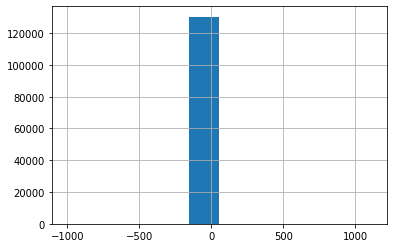

In [61]:
train_df['epoch_diff'].hist()

In [63]:
train_df['epoch_diff'].unique()

array([    0,    -1,   999,  1000,  1114, -1001,  1085])

In [64]:
train_df[train_df['epoch_diff'].abs() > 10]

,constellationType_0,constellationType_1,constellationType_2,constellationType_3,constellationType_4,constellationType_5,constellationType_6,constellationType_7,constellationType_8,constellationType_9,...,millisSinceGpsEpoch,epoch_diff,heightAboveWgs84EllipsoidM,timeSinceFirstFixSeconds,hDop,vDop,speedMps,courseDegree,latDeg,lngDeg
7,1,1,6,1,3,1,9999999999999,9999999999999,9999999999999,9999999999999,...,1273538844448,999,33.64,146.45,0.5,0.0,0.0,158.6,37.6901944475,-122.3923280958
639,1,1,6,1,1,3,3,3,1,3,...,1274120433430,999,38.43,1100.43,1.04,0.0,29.79,306.4,37.4688360446,-122.1550334186
2163,3,6,3,3,6,5,6,1,1,6,...,1275934390446,1000,67.82,506.45,1.01,0.0,25.18,176.35,37.378447026,-122.0678398939
5066,1,1,1,4,1,6,1,3,3,1,...,1293917234770,1114,69.25,1111.66,1.56,0.0,24.06,0.94,37.3778203486,-122.0675048195
5113,1,3,1,1,1,6,9999999999999,9999999999999,9999999999999,9999999999999,...,1293917285430,-1001,68.48,1164.43,0.0,0.0,24.76,178.02,37.3778062814,-122.0678123269
386,1,1,1,4,1,6,1,3,3,6,...,1293919152749,1085,69.23,667.66,1.86,0.0,25.8,0.94,37.3778168815,-122.0675142652
3460,3,1,1,3,1,3,9999999999999,9999999999999,9999999999999,9999999999999,...,1303161211446,1000,55.21,960.45,0.0,0.0,9.85,358.42,37.3353171958,-121.8974813991
5571,1,5,3,1,6,6,1,5,5,1,...,1303163324446,1000,58.43,3073.45,0.0,0.0,15.51,149.4,37.3332793194,-121.8967929176
4038,6,1,1,1,1,1,6,5,1,5,...,1303677135438,1000,55.13,2307.44,0.0,0.0,11.77,263.1,37.3353583734,-121.897091311
4696,6,6,3,6,1,1,3,1,6,5,...,1303760277435,1000,56.59,2593.43,0.8,0.0,0.0,60.0,37.3344727094,-121.8996116194


In [66]:
train_df = train_df[train_df['epoch_diff'].abs() < 10].reset_index(drop=True)
train_df

,constellationType_0,constellationType_1,constellationType_2,constellationType_3,constellationType_4,constellationType_5,constellationType_6,constellationType_7,constellationType_8,constellationType_9,...,millisSinceGpsEpoch,epoch_diff,heightAboveWgs84EllipsoidM,timeSinceFirstFixSeconds,hDop,vDop,speedMps,courseDegree,latDeg,lngDeg
0,3,6,1,6,6,1,3,6,6,1,...,1273529464442,0,33.21,552.44,1.1,0.0,0.0,12.7,37.4235759543,-122.0941320367
1,3,6,1,6,6,1,3,6,6,1,...,1273529465442,0,33.21,553.44,1.1,0.0,0.0,12.7,37.4235759647,-122.0941320333
2,3,6,1,6,6,1,3,6,6,1,...,1273529466442,0,33.2,554.44,1.1,0.0,0.0,12.7,37.4235759761,-122.0941320317
3,3,6,1,6,6,1,3,6,6,1,...,1273529467442,0,33.2,555.44,1.1,0.0,0.0,12.7,37.423575986,-122.0941320333
4,3,6,1,6,6,1,3,6,6,1,...,1273529468442,0,33.2,556.44,1.1,0.0,0.0,12.7,37.4235759995,-122.0941320367
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130324,6,6,1,6,5,3,6,1,1,1,...,1303760315000,0,56.62,2632.0,1.1,0.0,0.0,60.0,37.3344748283,-121.8996134267
130325,6,6,1,6,5,3,6,1,1,1,...,1303760316000,0,56.62,2633.0,1.1,0.0,0.0,60.0,37.3344748333,-121.8996134267
130326,6,6,1,6,5,3,6,1,1,1,...,1303760317000,0,56.62,2634.0,0.9,0.0,0.0,60.0,37.334474835,-121.8996134283
130327,6,6,1,6,5,3,6,1,1,1,...,1303760318000,0,56.63,2635.0,1.0,0.0,0.0,60.0,37.3344747917,-121.899613425


In [70]:
to_pickle(output_dir + 'train.pkl', train_df)

## test

In [75]:
import glob
import os
from tqdm.notebook import tqdm


def create_test_dataset(collection_path):

    output_df = pd.DataFrame()
    for phone_path in glob.glob(os.path.join(collection_path, '*')):

        # get derived file (only 1 file)
        for derived_path in glob.glob(os.path.join(phone_path, "*_derived.csv")):
            derived_df = pd.read_csv(derived_path)
    
        
        # merge derived and target by 'millisSinceGpsEpoch'
        rows = []
        for epoch, epoch_df in derived_df.groupby('millisSinceGpsEpoch'):

            collectionName = epoch_df.iloc[0, 0]
            phoneName = epoch_df.iloc[0, 1]
            millisSinceGpsEpoch = epoch_df.iloc[0, 2].astype(int)
            
            dummy_count = NUM_DATA - len(epoch_df)
            DUMMY_RECORD = [
                9999999999999,
                9999999999999,
                'NONE',
                9999999999999,
                9999999999999,
                9999999999999,
                9999999999999,
                9999999999999,
                9999999999999,
                9999999999999,
                9999999999999,
                9999999999999,
                9999999999999,
                9999999999999,
                9999999999999,
                9999999999999,
                9999999999999,
            ]
            use_columns = [
                'constellationType',
                'svid', 
                'signalType', 
                'receivedSvTimeInGpsNanos',
                'xSatPosM', 
                'ySatPosM', 
                'zSatPosM', 
                'xSatVelMps', 
                'ySatVelMps', 
                'zSatVelMps', 
                'satClkBiasM', 
                'satClkDriftMps',
                'rawPrM',
                'rawPrUncM',
                'isrbM',
                'ionoDelayM',
                'tropoDelayM'
            ]
            
            if len(epoch_df) < NUM_DATA:
                dummy_df = pd.DataFrame(np.tile(DUMMY_RECORD, (dummy_count, 1)), columns=use_columns)
                epoch_df = pd.concat([epoch_df, dummy_df])
            epoch_df = epoch_df.head(NUM_DATA).reset_index(drop=True)

            row = np.concatenate([
                epoch_df['constellationType'].to_numpy(),
                epoch_df['svid'].to_numpy().astype(int),
                epoch_df['signalType'].to_numpy(),
                epoch_df['receivedSvTimeInGpsNanos'].to_numpy().astype(int),
                epoch_df['xSatPosM'].to_numpy().astype(float),
                epoch_df['ySatPosM'].to_numpy().astype(float),
                epoch_df['zSatPosM'].to_numpy().astype(float),
                epoch_df['xSatVelMps'].to_numpy().astype(float),
                epoch_df['ySatVelMps'].to_numpy().astype(float),
                epoch_df['zSatVelMps'].to_numpy().astype(float),
                epoch_df['satClkBiasM'].to_numpy().astype(float),
                epoch_df['satClkDriftMps'].to_numpy().astype(float),
                epoch_df['rawPrM'].to_numpy().astype(float),
                epoch_df['rawPrUncM'].to_numpy().astype(float),
                epoch_df['isrbM'].to_numpy().astype(float),
                epoch_df['ionoDelayM'].to_numpy().astype(float),
                epoch_df['tropoDelayM'].to_numpy().astype(float),
                [
                    collectionName,
                    phoneName,
                    millisSinceGpsEpoch,
                ]
                ])
            rows.append(row)

        columns = [f'constellationType_{i}' for i in range(NUM_DATA)] + \
                  [f'svid_{i}' for i in range(NUM_DATA)] + \
                  [f'signalType_{i}' for i in range(NUM_DATA)] + \
                  [f'receivedSvTimeInGpsNanos_{i}' for i in range(NUM_DATA)] + \
                  [f'xSatPosM_{i}' for i in range(NUM_DATA)] + \
                  [f'ySatPosM_{i}' for i in range(NUM_DATA)] + \
                  [f'zSatPosM_{i}' for i in range(NUM_DATA)] + \
                  [f'xSatVelMps_{i}' for i in range(NUM_DATA)] + \
                  [f'ySatVelMps_{i}' for i in range(NUM_DATA)] + \
                  [f'zSatVelMps_{i}' for i in range(NUM_DATA)] + \
                  [f'satClkBiasM_{i}' for i in range(NUM_DATA)] + \
                  [f'satClkDriftMps_{i}' for i in range(NUM_DATA)] + \
                  [f'rawPrM_{i}' for i in range(NUM_DATA)] + \
                  [f'rawPrUncM_{i}' for i in range(NUM_DATA)] + \
                  [f'isrbM_{i}' for i in range(NUM_DATA)] + \
                  [f'ionoDelayM_{i}' for i in range(NUM_DATA)] + \
                  [f'tropoDelayM_{i}' for i in range(NUM_DATA)] + \
                  ['collectionName', 'phoneName', 'millisSinceGpsEpoch']
        df = pd.DataFrame(rows, columns=columns)
        output_df = pd.concat([output_df, df]).reset_index(drop=True)
    return output_df

In [76]:
processes = multiprocessing.cpu_count()
with multiprocessing.Pool(processes=processes) as pool:
    path_list = glob.glob(os.path.join(root_dir, 'test/*'))
    dfs = pool.imap_unordered(create_test_dataset, path_list)
    dfs = tqdm(dfs, total=len(path_list))
    dfs = list(dfs)
test_df = pd.concat(dfs).sort_values(['collectionName', 'phoneName','millisSinceGpsEpoch']).reset_index(drop=True)

  0%|          | 0/19 [00:00<?, ?it/s]

In [77]:
test_df

,constellationType_0,constellationType_1,constellationType_2,constellationType_3,constellationType_4,constellationType_5,constellationType_6,constellationType_7,constellationType_8,constellationType_9,...,tropoDelayM_33,tropoDelayM_34,tropoDelayM_35,tropoDelayM_36,tropoDelayM_37,tropoDelayM_38,tropoDelayM_39,collectionName,phoneName,millisSinceGpsEpoch
0,1,6,1,1,6,6,6,1,1,3,...,1.000000e+13,1.000000e+13,1.000000e+13,1.000000e+13,1.000000e+13,1.000000e+13,1.000000e+13,2020-05-15-US-MTV-1,Pixel4,1273608786431
1,1,6,1,1,6,6,6,1,1,3,...,1.000000e+13,1.000000e+13,1.000000e+13,1.000000e+13,1.000000e+13,1.000000e+13,1.000000e+13,2020-05-15-US-MTV-1,Pixel4,1273608787431
2,1,6,1,1,6,6,6,1,3,1,...,1.000000e+13,1.000000e+13,1.000000e+13,1.000000e+13,1.000000e+13,1.000000e+13,1.000000e+13,2020-05-15-US-MTV-1,Pixel4,1273608788431
3,1,6,1,1,6,6,6,1,1,3,...,1.000000e+13,1.000000e+13,1.000000e+13,1.000000e+13,1.000000e+13,1.000000e+13,1.000000e+13,2020-05-15-US-MTV-1,Pixel4,1273608789431
4,1,6,1,1,6,6,6,1,3,1,...,1.000000e+13,1.000000e+13,1.000000e+13,1.000000e+13,1.000000e+13,1.000000e+13,1.000000e+13,2020-05-15-US-MTV-1,Pixel4,1273608790431
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90416,6,6,5,6,1,1,1,6,5,6,...,1.000000e+13,1.000000e+13,1.000000e+13,1.000000e+13,1.000000e+13,1.000000e+13,1.000000e+13,2021-04-29-US-SJC-3,SamsungS20Ultra,1303763185000
90417,6,6,5,3,6,1,1,1,6,5,...,1.000000e+13,1.000000e+13,1.000000e+13,1.000000e+13,1.000000e+13,1.000000e+13,1.000000e+13,2021-04-29-US-SJC-3,SamsungS20Ultra,1303763186000
90418,6,6,5,3,6,1,1,1,6,5,...,1.000000e+13,1.000000e+13,1.000000e+13,1.000000e+13,1.000000e+13,1.000000e+13,1.000000e+13,2021-04-29-US-SJC-3,SamsungS20Ultra,1303763187000
90419,6,6,5,3,6,1,1,1,6,5,...,1.000000e+13,1.000000e+13,1.000000e+13,1.000000e+13,1.000000e+13,1.000000e+13,1.000000e+13,2021-04-29-US-SJC-3,SamsungS20Ultra,1303763188000


In [78]:
to_pickle(output_dir + 'test.pkl', test_df)